In [2]:
addpath('C:\Users\barry\Documents\Academics\Quantecon-Notes\functions')
addpath('C:\Users\barry\Documents\Academics\Quantecon-Notes\functions\CEtools')
addpath('C:\Users\barry\Documents\Academics\Quantecon-Notes\functions\CEtools\public')
cd 'C:\Users\barry\Documents\Academics\Quantecon-Notes\functions'

> In path (line 109)
  In addpath (line 86)



# Chapter 10: Continuous Time 

## Arbitrage Based Asset Valuation

Consider two assets with values $V$ and $W$, both depend on random process $dS = \mu_s dt+\sigma_s dz$. Since it is Ito process, it means the $V$ and $W$ are Ito process and are of form $dV = \mu_V dt+\sigma_V dz$, $dW = \mu_W dt + \sigma_W dz$. 

Suppose each asset generates income processes $\delta_V$ and $\delta_W$. A portfolio with one unit of $V$ and $h$ unit of $W$ will have value 
$$
dV + hdW = [\mu_V+h\mu_W]dt+[\sigma_V+h\sigma_W]dz
$$
Choose $h = -\frac{\sigma_V}{\sigma_W}$, we have the portfolio to be risk free, and therefore, 
$$
[\mu_V-\frac{\sigma_V}{\sigma_W}\mu_W]dt + [\delta_V -\frac{\sigma_V}{\sigma_W}\delta_W]dt = r[V-\frac{\sigma_V}{\sigma_W}]dt
$$
Thus, for any asset, we must have 
$$
\frac{\mu_V+\delta_V-rV}{\sigma_V} = \frac{\mu_W+\delta_W-rW}{\sigma_W} = \theta
$$
where $\theta$ is the same for any asset. So the total return must equal to risk free rate plus a risk adjustment: $\mu_V+\delta_V = rV+\theta \sigma_V$

Ito's lemma: $\mu_V = V_t+\mu_SV_S+\frac{1}{2}\sigma_S^2 V_{SS}$ and $\sigma_V = \sigma_SV_S$. So we have PDE
$$
rV = \delta_V + V_t + (\mu_S - \theta\sigma_S)V_S + \frac{1}{2}\sigma^2_S V_{SS}
$$

**<span style="color:red">When using finsolve, better to use linear function space with large number of nodes. Eg. n=200; fspace = ('lin',n, smin, smax). Also only uses 'lines' option in finsolve. Eg. finsolve(model, fspace, 'lines', s)</span>**

### Example: Bond pricing

Suppose the rate of interest is described by $dr = \mu(r) dt + \sigma(r) dz$ in the risk-neutral process. A bond paying 1 at $T$ satisfies PDE 

$$
rB = B_t + \mu(r) B + \frac{1}{2}\sigma(r)^2 B_{rr}
$$
with BC $B(r,T)=1$

Suppose CIR (Cox-Ingersol_ross) process for interest rate: $dr = \kappa (\alpha - r)dt + \sigma \sqrt{r}dz$. Express bond value in terms of time-to-maturity ($B(S,t) = V(S, \tau = T-t)$ so $V_\tau = -B_t$), we have 
$$
V_\tau = \kappa (\alpha - r) V_r + \frac{1}{2}\sigma^2rV_{rr}-rV
$$
with initial condition $V(r, 0) = 1$. 

In [6]:
%%file functions\bond_pricing.m
function out = bond_pricing(flag, S, kappa, alpha, sigma)
n = size(S,1);
switch flag
case 'rho'
out = S;
case 'mu'
out = kappa*(alpha-S);
case 'sigma'
out = sigma*sqrt(S);
case 'delta'
out = [];
case 'V0'
out = ones(n,1);
end

Created file 'C:\Users\barry\Documents\Academics\Quantecon-Notes\functions\bond_pricing.m'.


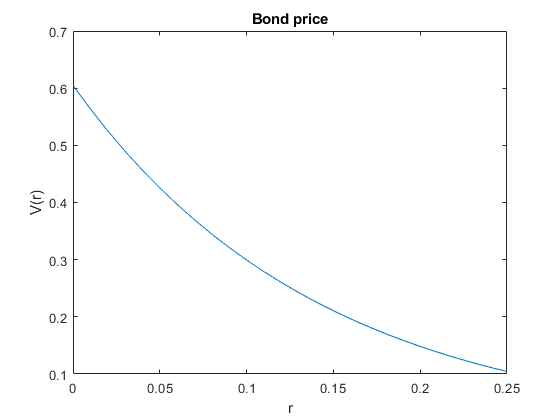

In [27]:
clear all;
T = 20;
kappa = 0.1;
alpha = 0.05;
sigma = 0.1;

n = 200;
fspace = fundefn('lin', n, 0, 2);

model.func = 'bond_pricing';
model.T = T;
model.american = 0;
model.params = {kappa, alpha, sigma};
s = funnode(fspace);
c = finsolve(model, fspace, 'lines', s, 1);

x=linspace(0,0.25,201)';
V = funeval(c(:,end), fspace, x);

figure(1)
plot(x, V);
title('Bond price')
xlabel('r')
ylabel('V(r)')

#### Example: Black-Scholes Formula

Suppose $dS = \mu Sdt + \sigma Sdz$, the log difference $\ln{S(t+\Delta t)} - \ln{S(t)}$ is distributed with mean $(\mu - \frac{1}{2}\sigma^2)\Delta t$ and variance is $\sigma^2 \Delta t$. 

It must satisfy the PDE $rV = V_t + rSV_S + \frac{1}{2}\sigma^2 S^2 V_{SS}$ with boundary condition $V(S,T) = \max[0, S-K]$, or put in terms of $\tau = T-t$, the PDE is 
$$
rV = -V_\tau + rSV_S + \frac{1}{2}\sigma^2 S^2 V_{SS}
$$
with initial condition $V(S,0) = \max[S-K,0]$

In [13]:
%%file functions\black_scholes.m
function out = black_scholes(flag, S,r,deltaS, sigma, K, put);
switch flag
case 'rho'
out = r+zeros(size(S,1),1);
case 'mu'
out = (r-deltaS)*S;
case 'sigma'
out = sigma*S;
case 'delta'
out = [];
case 'V0'
if put
out = max(0,K-S);
else 
out = max(0,S-K);
end
end

Created file 'C:\Users\barry\Documents\Academics\Quantecon-Notes\functions\black_scholes.m'.


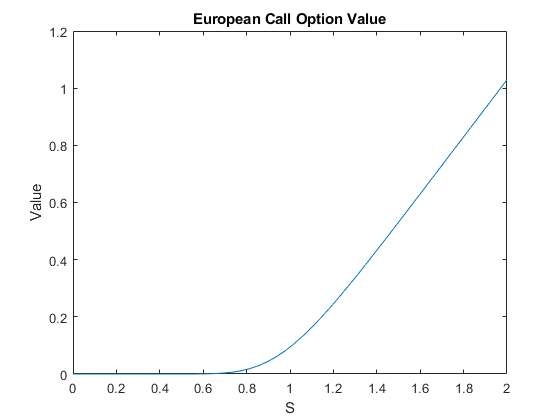

In [33]:
clear all;
r = 0.03;
deltaS = 0; % Dividend rate
sigma = 0.2;
K = 1;
put = 0;
T = 1;

model.func = 'black_scholes';
model.T = T;
model.params = {r, deltaS, sigma, K, put};
model.american = 0;

n = 50;
fspace = fundefn('lin',n, 0, 2*K);
s = funnode(fspace);

S = linspace(0, 2*K, 500)';
c = finsolve(model, fspace, 'lines', s);

figure(1)
plot(S, funeval(c, fspace, S));
title('European Call Option Value')
xlabel('S')
ylabel('Value')

#### Example: Asian Option

An asian option's payout depends on the average price of the underlying asset over some period. Define $S$ to be the underlying price and let asian option depends on $A = \frac{1}{T}\int_0^T S_t dt$. 

The average strike Asian call option pays $\max(S-A, 0)$ and the fixed strike Asian call option with strike price $K$ pays $\max(A-K,0)$. Suppose $dS = \mu_S dt + \sigma_S dW$. The state space depends on $S,t$, and $C_t = \int_0^t S_\tau d\tau$. Since $dC = Sdt$, the option satisfies the usual no-arbitrage PDE:
$$
rV = V_t + \mu_S V_S + SV_C + \frac{1}{2}\sigma^2_S V_{SS}
$$
with boundary condition $V(S,C,T) = \max(S-C/T,0)$ or $V(S,C,T) = \max(C/T-K,0)$, which is a two-dimensional PDE. If $S$ satisfies geometric Brownian motion, we can guess $V = Cv(S,t)$ and we can simplify the PDE to be 
$$
(r-y)v = v_t + (r-y)yv_y + \frac{1}{2}\sigma^2y^2v_{yy}
$$
where $y = S/C$

#### Example: American Put Option

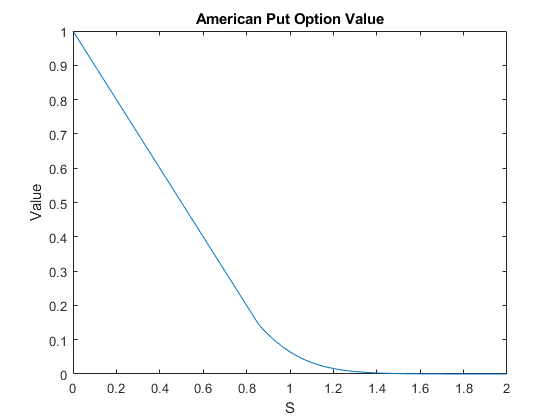

In [42]:
clear all;
r = 0.03;
deltaS = 0; % Dividend rate
sigma = 0.2;
K = 1;
put = 1;
T = 1;

model.func = 'black_scholes';
model.T = T;
model.params = {r, deltaS, sigma, K, put};
model.american = 1;

n = 200;
fspace = fundefn('lin',n, 0, 2*K);
s = funnode(fspace);

[c,V] = finsolve(model, fspace, 'lines', s);

figure(1)
plot(s, V);
title('American Put Option Value')
xlabel('S')
ylabel('Value')

#### Example: Barrier Option

A barrier option behaves like a normal option as long as the underlying price stays above the barrior $B$. If it drops below $B$, the option is terminated with some rebate $R$ paid to the holder. 

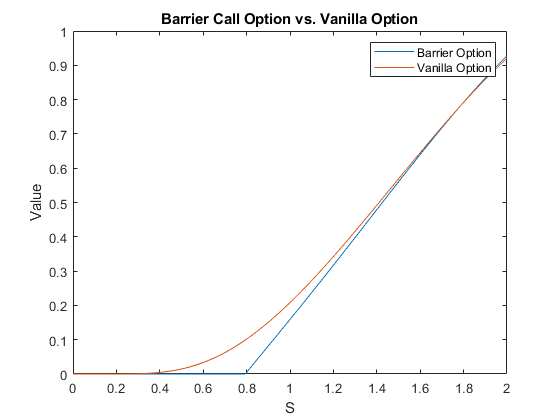

In [53]:
clear all;
r = 0.03;
deltaS = 0; % Dividend rate
sigma = 0.5;
K = 1;
put = 0;
T = 1;

Sb = 0.8; % Barrier

model.func = 'black_scholes';
model.T = T;
model.params = {r, deltaS, sigma, K, put};
model.american = 0;
model.barrier = [0 Sb 1; 0 inf 1];

n = 200;
fspace = fundefn('lin',n, 0, 2*K);
s = funnode(fspace);

[c,V] = finsolve(model, fspace, 'lines', s);

clear model
model.func = 'black_scholes';
model.T = T;
model.params = {r, deltaS, sigma, K, put};
model.american = 0;

[c,Vbs] = finsolve(model, fspace, 'lines', s);

figure(1)
plot(s, V,s,Vbs);
title('Barrier Call Option vs. Vanilla Option')
legend({'Barrier Option','Vanilla Option'});
xlabel('S')
ylabel('Value')

## Stochastic Control Problem

For non-stochastic optimization problem, we solve 
$$
\max_{x(S,t)} \int_0^T e^{-\rho t}f(S,x)dt + e^{-\rho T}R(S(T)), \text{ s.t. } dS = g(S,x)dt 
$$
where $S$ is the state variable, $x$ is control and $R(S(T))$ is the terminal value. For small $\Delta t$, he Bellman equation can be written as (using $e^{-\rho\Delta t}\approx \frac{1}{1+\rho \Delta t}$)
$$
V(S,t) = \max_x (f(S,x)\Delta t + \frac{1}{1+\rho \Delta t}E_t[V(S_{t+\Delta t}, t+\Delta t)])
$$
Multiply by $(1+\rho \Delta t)/\Delta t$ and rearranging:
$$
\rho V(S,t) = \max_x (f(S,x)(1+\rho \Delta t) + \frac{E_t[V(S_{t+\Delta t},t+\Delta t) - V(S,t)]}{\Delta t}
$$
Take $\Delta t\rightarrow 0$, we have
$$
\rho V(S,t) = \max_x [f(S,x)+\frac{E_tdV(S,t)}{dt}]
$$
Suppose the state varible follows process $dS = g(S,x)dt + \sigma(S)dz$, by Ito's Lemma, 
$$dV = [\frac{\partial V}{\partial t} + g(S,x)\frac{\partial V}{\partial S} + \frac{1}{2}\sigma^2(S)\frac{\partial^2 V}{\partial S^2}]dt + \sigma(S)\frac{\partial V}{\partial S}dz$$
Take expectation (the $dz$ term will drop out) and divide by $dt$, we have $\frac{E_t dV(S,t)}{dt} = \frac{\partial V}{\partial t} + g(S,x)\frac{\partial V}{\partial S} + \frac{1}{2}\sigma^2(S)\frac{\partial^2 V}{\partial S^2}$. Replace into the Bellman equation and we have the HJB equation
$$
\rho V = \max_x [f(S,x) + \frac{\partial V}{\partial t} + g(S,x)\frac{\partial V}{\partial S} + \frac{1}{2}\sigma^2(S)\frac{\partial^2 V}{\partial S^2}]
$$
The optimization part is solved by FOC: 
$$
\frac{\partial f(S,x)}{\partial x} + \frac{\partial g(S,x)}{\partial x}\frac{\partial V}{\partial S} = 0
$$
Two equations with two unknown functions $x = x(S,t)$ and $V = V(S,t)$.Notice that Bellman's Equation is not stochastic; the expectation operator and the randomness in the problem have been eliminated by using Ito's Lemma.

In infinite horizon problem, the value function becomes time invariant so $\frac{\partial V}{\partial t} = 0$. Therefore the bellman equation simplifies to 
$$
\rho V = \max_x [f(S,x) + g(S,x)\frac{\partial V}{\partial S} + \frac{1}{2}\sigma^2(S)\frac{\partial^2 V}{\partial S^2}]
$$

### Boundary Condition
Boundary conditions are justified by economic reason rather than math. 

If $U(c) = \frac{c^\lambda -1}{\lambda}$, then we must have $V(0) = -\infty$ and $V_S(0) = \infty$. 

For a single state problem, this means that there are two boundary conditions needed. In a two-dimensional problem with only one stochastic state variable, we will need two boundary conditions for the stochastic state and one for the non-stochastic one. Suppose HJB equation 
$$
\rho V = f(S,t,x) + \frac{\partial V}{\partial t} + g(S,t,x)\frac{\partial V}{\partial S} + \frac{1}{2}\sigma^2(S)\frac{\partial^2 V}{\partial S^2}
$$
we must specify one condition for $t = t_b$ (e.g. $V(S,t=0) = H(S)$) and condition at $S = S_0$ and $S = \bar{S}$, say $V_{S}(S_0, t)$ and $V_S(\bar{S},t)$

If the process of state variable has variance 0 at the boundary, we don't need to specify the boundary condition

### Euler Equation Methods

Euler Equation method is most useful in deterministic problem. In an infinite horizon problem, suppose $dS = g(x,S)dt$, the bellman equation is therefore
$$
\rho V = \max_x f(S,x) + g(S,x)\frac{\partial V}{\partial S}
$$
with FOC
$$
\frac{\partial f(S,x)}{\partial x} + \frac{\partial g(S,x)}{\partial x}\frac{\partial V}{\partial S} = 0
$$
Let $h(x,S) = -\frac{\partial f}{\partial x}/\frac{\partial g}{\partial x}$, we have $V'(S) = h(x,S)$. Use the Envelope Theorem to Bellman equation (take derivative with respect to $V$)
$$
(\rho - \frac{\partial g}{\partial S})V'(S) - \frac{\partial f}{\partial S} = g(x,S)V''(S)
$$

Take derivative of $h(x,S) = V'(S)$, we can solve for $V''(S) = h_S(x,S) + h_x(x,S)\frac{dx}{dS}$. Combining two equations,
$$
(\rho - \frac{\partial g}{\partial S})h(x,S) - \frac{\partial f}{\partial S} = g(x,S)[h_S(x,S) + h_x(x,S)\frac{dx}{dS}]
$$

#### Example: Optimal Renewable Resource Extraction

The resource is controlled by process $dS = (B(S) - q)dt + \sigma Sdz$. The marginal cost of harvesting is $C(q) = c(S)q$. The total surplus is $f(S,q) = \int_0^q D^{-1}(z)dz - c(S)q$ where $D$ is the demand function. 

With discount rate $\rho$, the Bellman Equation for this optimization problem is $$\rho V = \max_q \int_0^q D^{-1}(z)dz - c(S)q + (B(S)-q)V_S + \frac{1}{2}\sigma^2 S^2 V_{SS}$$

FOC: 
$$
D^{-1}(q) - c(S) - V_S(S) = 0 \text{ or } q^* = D(c(S)+V_S(S))
$$

Suppose $B(S) = \frac{\alpha}{\beta}S(1-(S/K)^\beta), D(p) = bp^{-\eta}, c(S) = cS^{-\gamma}$

In [54]:
%%file functions\renewable_resource.m

function [out1, out2] = renewable_resource(flag, s,x,Vs,alpha,beta,K,b,eta,C,gamma,sigma,rho)
switch flag
case 'foc'
Cost = C*c.^(-gamma);
out1 = b*x.^(-1/eta)-Cost - Vs;
out2 = -(b/eta)*x.^(-1/eta-1);
case 'x'
Cost = C*s.^(-gamma);
out1 = b*(Cost+Vs).^(-eta);
case 'f'
Cost = C*s.^(-gamma);
if eta~=1
factor1  =1-1/eta;
factor0 = b.^(1/eta)/factor1;
out1 = factor0*x.^factor1-Cost.*x;
else
out1 = b*log(x)-Cost.*x;
end
case 'g'
if beta ~= 0
Growth = alpha/beta*s.*(1-(s/K).^beta);
else
Growth = alpha*s.*log(K./s);
end
out1 = Growth - x;
case 'sigma'
out1 = sigma*s;
case 'rho'
out1 = rho+zeros(size(s,1),1);
end

Created file 'C:\Users\barry\Documents\Academics\Quantecon-Notes\functions\renewable_resource.m'.


In [65]:
clear all
alpha = 0.5;
beta = 1;
K = 1;
b = 1;
eta = 0.5;
c = 5;
gamma = 2;
sigma = 0.1;
rho = 0.05;


model.func = 'renewable_resource';
model.params = {alpha, beta, K,b,eta,c,gamma,sigma, rho};

n = 50;
smin = 0.2;
smax = 1.2;
fspace = fundefn('cheb',n,smin,smax);
s = funnode(fspace);

[cv,S,v,x,resid] = scsolve(model,fspace,s);

  Running this M file version may be significantly slower and more memory intensive.
  Use MEXALL to create the executable (MEX or DLL) and make sure it is on the MATLAB path.
> In scsolve (line 128)

  1   7.2138e+02
> In scsolve (line 128)

  2   4.2458e+02
  3   3.2282e+01
  4   4.4477e-01
  5   4.2779e-04
  6   1.1423e-03
  7   5.8612e-04
  8   1.8258e-04
  9   1.7433e-04
 10   1.2932e-05
 11   7.3003e-04
 12   4.9139e-04
> In scsolve (line 128)

 13   3.4576e-03
 14   1.3892e-03
 15   8.4152e-04
 16   5.7217e-04
 17   3.4335e-04
 18   2.2207e-04
 19   4.8174e-04
 20   1.0913e-04
 21   1.2032e-03
 22   4.9895e-04
 23   2.1862e-04
 24   5.1986e-06
 25   7.7084e-05
 26   3.7691e-04
> In scsolve (line 128)

 27   3.6281e-03
 28   1.4255e-03
 29   8.8274e-04
 30   5.9829e-04
 31   4.2824e-04
 32   7.0372e-04
 33   1.7342e-04
 34   8.9648e-05
 35   1.2570e-03
 36   2.3692e-04
 37   5.4895e-04
> In scsolve (line 128)

 38   3.6580e-03
 39   1.4420e-03
 40   8.6580e-04
 41   5.6797e-04
 4

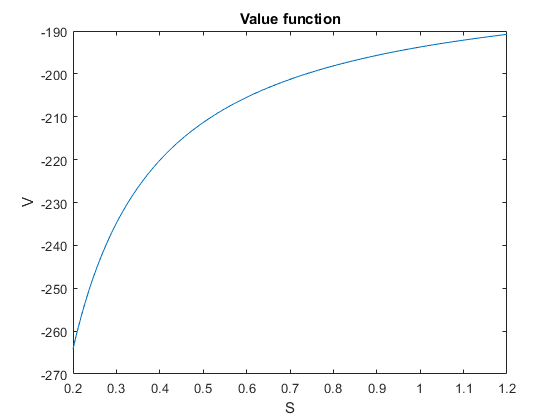

In [61]:
figure(1)
plot(S, funeval(cv,fspace,S))
title('Value function')
xlabel("S")
ylabel('V')

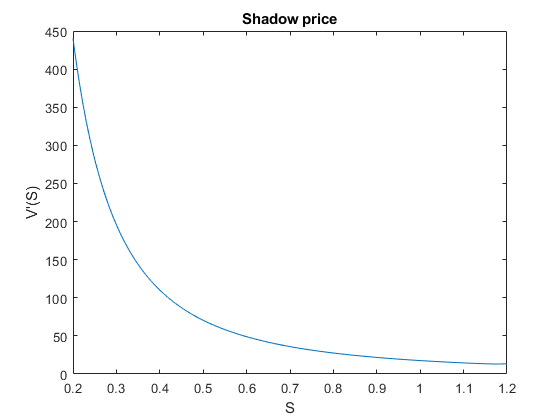

In [62]:
figure(1)
plot(S, funeval(cv,fspace,S,1))
title('Shadow price')
xlabel("S")
ylabel('V''(S)')

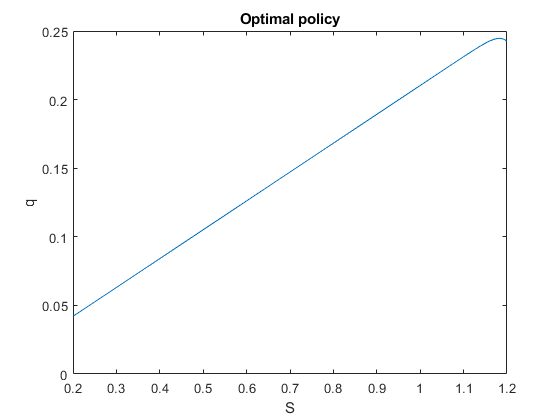

In [63]:
qa=feval(model.func,'x',S,[],Vsa,model.params{:});
figure(3)
plot(S,qa)
title('Optimal policy')
xlabel('S')
ylabel('q')

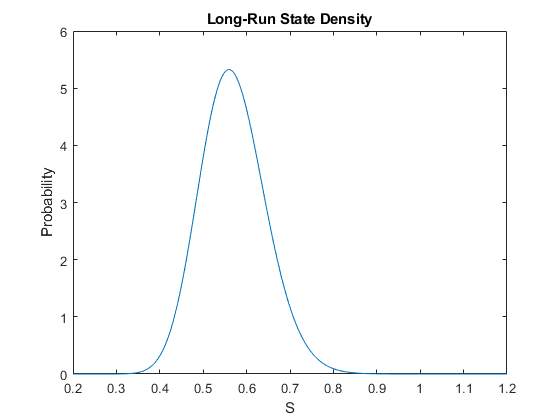

In [68]:
[cp,Ex]=itodensity(model,fspace,cv);
plot(S,funeval(cp,fspace,S))
title('Long-Run State Density')
xlabel('S')
ylabel('Probability')
% set lower y limit to 0
yy=get(gca,'ylim');yy(1)=0; set(gca,'ylim',yy); 

In [70]:
% Expected value for state variable
Ex


Ex =

    0.5694


